In [8]:
%load_ext autoreload
%autoreload 2

import io
import matplotlib.pyplot as plt
import numpy as np
import os, sys
from scipy.stats import spearmanr
import sqlite3
import torch
from tqdm import tqdm

sys.path.insert(0, '../src')
sys.path.insert(1, '..')

from main import get_model
from models.config import Config, IMAGE_TOKEN_IDS
import db_utils, visualizations, utils, similarity_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
# TODO: Update config file
# Qwen2-VL-2B-Instruct Attention Values
config_path = '../configs/models/qwen/Qwen2-VL-2B-Instruct-VisualBlocks_AttnValues.yaml'
# Qwen2-VL-7B-Instruct Hidden Representations
# config_path = '../configs/models/qwen/Qwen2-VL-7B-Instruct-VisualBlocks.yaml'
# LLaVA-1.5-7B Hidden Representations
# config_path = '../configs/models/llava/LLaVA-1.5-7B-VisualBlocks.yaml'

sys.argv = ['notebooks/track_mean_sims_across_layers.ipynb',
            '--config', config_path]

config = Config()
model = get_model(config.architecture, config)
utils.informal_log("Using {}".format(config.get_model_id()))
# Print # parameters and model architecture
utils.informal_log("{:.3f}B parameters".format(model.model.num_parameters() / 1e9))
utils.informal_log(model.model)

Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  7.13it/s]


[1022_110452] Using Qwen2-VL-2B-Instruct
[1022_110452] 2.209B parameters
[1022_110452] Qwen2VLForConditionalGeneration(
  (visual): Qwen2VisionTransformerPretrainedModel(
    (patch_embed): PatchEmbed(
      (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
    )
    (rotary_pos_emb): VisionRotaryEmbedding()
    (blocks): ModuleList(
      (0-31): 32 x Qwen2VLVisionBlock(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): VisionSdpaAttention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (mlp): VisionMlp(
          (fc1): Linear(in_features=1280, out_features=5120, bias=True)
          (act): QuickGELUActivation()
          (fc2): Linear(in_features=5120, out_features=1280, bias=True)
        )
      )
    )
    (merger): PatchMerger

In [14]:
n_modules = 0
for name, module in model.model.named_modules():
    if model.config.matches_module(name):
        print(name)
        n_modules += 1
print("{} modules matched".format(n_modules))

visual.blocks.0.attn.qkv
model.layers.0.self_attn.v_proj
2 modules matched


In [19]:
db_path = model.config.output_db
utils.informal_log("Database path: {}".format(db_path))
proceed = True
if os.path.exists(db_path):
    response = input("File exists at {}. Are you sure you want to overwrite? (Y/N)".format(db_path))
    if response.lower() != "y":
        proceed = False

if proceed:
    # Run model on images
    model.run(save_tokens=True)
else:
    utils.informal_log("Not overwriting file at {}".format(db_path))

[1022_113202] Database path: ../output/Qwen2-VL-2B-Instruct/AttentionValues.db


Running forward hooks on data: 100%|██████████| 2/2 [00:00<00:00,  6.71it/s]


In [ ]:
db_path = model.config.output_db
utils.informal_log(db_path)
connection = sqlite3.connect(db_path)
connection.row_factory = sqlite3.Row
cursor = connection.cursor()

for r in cursor.execute("""
  SELECT layer, tensor
  FROM tensors
  LIMIT 20
"""):
    tensor_bytes = r['tensor']
    tensor = torch.load(io.BytesIO(tensor_bytes), map_location='cpu', weights_only=False)

    print(r['layer'], tensor.shape)

connection.close()

[1022_105959] ../output/Qwen2-VL-2B-Instruct/AttentionValues.db
input_ids torch.Size([1, 172])
visual.blocks.0.attn.qkv torch.Size([576, 3840])
model.layers.0.self_attn.v_proj torch.Size([1, 172, 256])
input_ids torch.Size([1, 172])
visual.blocks.0.attn.qkv torch.Size([576, 3840])
model.layers.0.self_attn.v_proj torch.Size([1, 172, 256])
input_ids torch.Size([1, 172])
visual.blocks.0.attn.qkv torch.Size([576, 3840])
model.layers.0.self_attn.v_proj torch.Size([1, 172, 256])
input_ids torch.Size([1, 172])
visual.blocks.0.attn.qkv torch.Size([576, 3840])
model.layers.0.self_attn.v_proj torch.Size([1, 172, 256])
input_ids torch.Size([1, 172])
visual.blocks.0.attn.qkv torch.Size([576, 3840])
model.layers.0.self_attn.v_proj torch.Size([1, 172, 256])
input_ids torch.Size([1, 172])
visual.blocks.0.attn.qkv torch.Size([576, 3840])
model.layers.0.self_attn.v_proj torch.Size([1, 172, 256])
input_ids torch.Size([1, 172])
visual.blocks.0.attn.qkv torch.Size([576, 3840])


In [27]:
# Extract attention values from qkv

def get_attention(db_path,
                  layer_name,
                  unwrap_fn,
                  component="value"):
    assert component in ["query", "key", "value"], \
        "Unrecognized component: {}".format(component)

    embeddings_data = db_utils.get_embeddings_by_layer(
        db_path=db_path,
        layer_name=layer_name)
    embeddings, are_same_shapes = db_utils.unwrap_embeddings(embeddings_data)
    if "qkv" in layer_name:
        qkv = unwrap_fn(embeddings)

    if component == "query":
        return qkv[0, ...]
    elif component == "key":
        return qkv[1, ...]
    else: # value
        return qkv[2, ...]

attn_value = get_attention(
    db_path=db_path,
    layer_name="visual.blocks.0.attn.qkv",
    unwrap_fn=model.unwrap_qkv(),
    component="value"
)
print(attn_value.shape)


(2, 576, 1280)


In [23]:
# Compute image-pair similarities per layer

module_names, module_embeddings, module_similarities = similarity_utils.compute_image_pair_similarities(
    database_path=db_path,
    model=model,
    layer_names=None,
    # layer_names=["language_model.model.layers.0"],
    modalities=['vision', "text+vision"])

100%|██████████| 58/58 [17:36<00:00, 18.21s/it]


<Figure size 640x480 with 0 Axes>

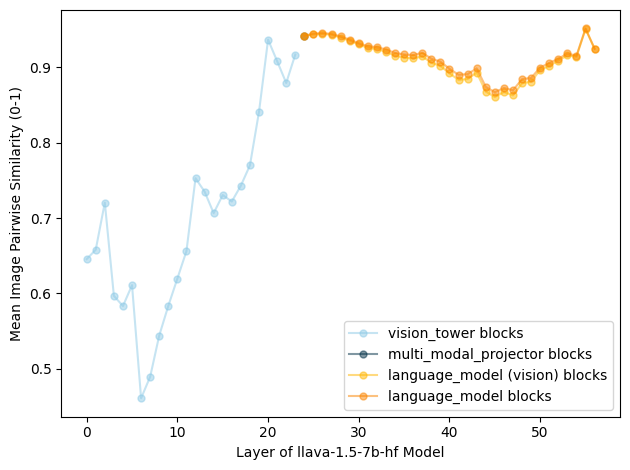

In [30]:
# Computer mean similarity at each layer (using vision or vision + text)
# and plot

mean_embeddings, mean_similarities = similarity_utils.plot_similarities(
    module_names=module_names,
    module_embeddings=module_embeddings,
    module_similarities=module_similarities,
    vision_key=model.get_vision_key(),
    model_name=model.config.get_model_id())